# **Nuclear Cell Counter**
***

## Description
Program to count cell that have nuclear or cytosolic signals. It will also quantify the results and make a bar plot to show them.

## How to use
The script *should* run without a problem, as long as it is provided with the correct folder structure and labeling. If this is not the case than unexpected behaviour may occur during runtime and it is recommended to follow the steps in the following section carefully. This will ensure the least amounts of errors.

### Known limits
- You cannot use more than 9 pictures of one treatment and one sample variant, because the sample names cap out at XX-YYY-9 and going over will result in problems with the data processing. (Will be fixed later.)
- DataCollector will sequentially do each sample. One after another, maybe the process can be speed up using multithreading. (Will have to look at that)

### Pre-requisite
Because the script is skimming through subfolders in a particular way, it is required to have a certian folder structure ready before you start. The labeling of the samples is also important, because the data sorting relies heavily on sample names, such that it will group samples from the same treatment for the summary. We will now look at how we need to create these labels and folder structures, in order to work with this script.

1. Create a folder. The name of this folder is not important for the script and can be called howere you want.

1. Inside this folder create a folder for each treatment you want to look at. Label each treatment with a 3 letter code.
    - Example: If I want to look at the exponential phase, Rapamycine treatment and Cyclohexamide treatment, then I need 3 folders. One for Rapamycine called RAP, one for Cyclohexamide called CHX and one for the exponential phase called EXP.
    <br>

1. Now go inside one of these newly created folders and make a folder for each sample variant you have. The sample variants should be distinguishable via a 2 letter code.
    - If we enter the EXP folder from the previous step, we should see nothing inside of it, because we just made it. Inside here we make new folders. I have three different samples that I want to test:
        - RTG3-GFP-WT
        - RTG3-GFP-8A
        - RTG3-GFP-8E
    - Because I have 3 samples I will need to make 3 folders and because each folder can only have 2 letters to describe the sample my folders that I will put inside EXP will be called:
        - WT
        - 8A
        - 8E 
        <br>

1. Exit the folder and repeat the previous step until all new folders have the same subfolders.
    - In folder EXP I already have WT, 8A, 8E, but I still have the folders RAP and CHX, which need the same subfolder structure.
    <br>

1. Now we have the correct folder structure, but the pictures are still missing. To fix that it's now time to processe the microscopy pictures in fiji. I use the Z-Stack function to make stacks from my pictures and save the results inside of each corresponding folder with an additional index at the end, the filename also corresponds to the folder structure.
    - If I have processed a picture from WT in EXP I will safe it inside the folder EXP and there inside the folder WT with the name WT-EXP-1. If I have a second one I will safe it at the same place but as WT-EXP-2 and so on and so forth.

1. Once you have all of this you will need to note the path to your folder. This path will replace the value of Path and will guid the program to the folder with all your pictures. Additionally write down or memorize the all 3 letter and 2 letter codes used in the previous steps. These will replace the values inside Conditions and Samples variables.

1. Proceed to the section called [Main](#Main).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
from scipy import ndimage as ndi
from cellpose import models
import time
import os

## Functions
This section defines the functions that run at the end of the script. This includes loading of the images, creation of mask and processing.

### NucCounter
This function takes an image path and loads it using the skimage package. The function then sets parameters for __[cellpose](https://www.cellpose.org/)__, which is a package that analyzes microscopy pictures and distinguishes cells from each other. From this distinction a mask is created, which will be labeled so that each connected area is considered a cell. Each cell has then its mean and max intensity extracted using skimage.measure.regionprops_table. The final step takes the difference of these two values and filters it using a threshold set by the user. The items in each list are counted and saved as Nuclear, Cytosoic or Total number of cells. The function then returns these values.

### DataCollector
This function takes the path to the pictures and all the other options to skim through the provided folder and collect all the wanted data. But first of all it changes the working directory to the provided path. This ensures that the script runs in the correct place and not somewhere unwanted.
The next step is creating an empty DataFrame from pandas. The only thing provided are the Values, which are the column titles. Each value collected will be placed in a column and the values are passed in by the user. The function then iterates through all provided folders and subfolders and invoces the NucCounter function for each sample found.

In [2]:
def NucCounter(image, model_type='cyto', intensity_threshold=150, diameter=60, channels=[[0,0]],region_props_Select=('intensity_mean','intensity_max')):
    # Loading the provided image via skimage.io
    img = skimage.io.imread(image)

    # Setting model for the cellpose algorithm and running it to generate a mask for the current image.
    model = models.Cellpose(model_type=model_type)
    masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=channels)

    # Creating a labeled mask for the regionprops_table and extracting the mean and maximum intensity of each labeled cell.
    img_labeled = skimage.measure.label(masks)
    region_data = skimage.measure.regionprops_table(img_labeled,img,('intensity_mean','intensity_max'))

    # Here the difference in instensity from the mean is calculated and those values above the intensity_threshold are kept as nuclear signals.
    # Additionally the intensity values of the nuclear signals are storred.
    delta_intensity = region_data[region_props_Select[1]]-region_data[region_props_Select[0]]
    Nuclear_Intensity = delta_intensity[delta_intensity > intensity_threshold]
    NumNuclear = len(Nuclear_Intensity)
    NumTotal = len(delta_intensity)
    NumCyto = NumTotal - NumNuclear

    return NumNuclear, NumTotal, NumCyto

def VacPrep (image):
    # Importing the image via skimage 
    img = skimage.io.imread(image)

    # Enhancing the image so the vacuoles are better visible.
    footp = skimage.morphology.square(20)
    img_enh = skimage.filters.rank.enhance_contrast(img,footprint=footp)

    # Setting model for the cellpose algorithm and running it to generate a mask for the current image.
    model = models.Cellpose(model_type='cyto')
    masks, flows, styles, diams = model.eval(img, diameter=60, channels=[[0,0]])

    # Creating a labeled mask for the regionprops_table and extracting the mean and maximum intensity of each labeled cell.
    regprops = skimage.measure.regionprops(masks,img)

    return regprops

def VacCounter(regionProperties):
    regprops = regionProperties
    NumVac = 0
    NumNonVac = 0
    NumNull = 0

    for index in range(0,len(regprops)):
        subImg = regprops[index]['image_intensity']

        footp = skimage.morphology.square(2)
        contrast = skimage.filters.rank.enhance_contrast(subImg, footp)


        thresh = contrast > 20

        whole = ndi.binary_fill_holes(thresh)

        mask2 = skimage.measure.label(whole)
        regP = skimage.measure.regionprops(mask2,subImg)

        if len(regP) == 0:
            area = 0
        else:
            area = regP[0]['area']
            for ampdex in range(0,len(regP)):
                cArea = regP[ampdex]['area']
                if area < cArea:
                    area = cArea
        
        if area > 200:
            NumVac = NumVac + 1
        elif area == 0:
            NumNull = NumNull + 1
        else:
            NumNonVac = NumNonVac + 1        
    NumTot = len(regprops)
    return NumTot, NumVac, NumNonVac, NumNull


def DataCollector(Path, Conditions, Samples, Values, options):
    # Changing the working directory for the program. So that it can access the files
    init_pwd = os.getcwd()
    os.chdir(Path)

    # Creating an empty Dataframe with columns defined by the Values list.
    Data = pd.DataFrame(columns=Values)

    for index in Conditions:
        for undex in Samples:
            FileList = os.listdir('./{}/{}'.format(index,undex))
            for subdex in FileList:
                Nuc,Total,Cyto = NucCounter(
                    image='./{}/{}/{}'.format(index,undex,subdex),
                    model_type=options['model_type'],
                    intensity_threshold=options['intensity_threshold'],
                    diameter=options['diameter'],
                    channels=options['channels'],
                    region_props_Select=options['region_props_Select']
                    )
                New_Row = pd.Series({
                    Values[0]:subdex[4:-10],
                    Values[1]:undex,
                    Values[2]:index,
                    Values[3]:Nuc,
                    Values[4]:Total,
                    Values[5]:Cyto
                })
                Data = pd.concat([Data, New_Row.to_frame().T], ignore_index=True)
                print('Sample {} analyzed'.format(subdex[4:-8]))
    
    os.chdir(init_pwd)
    return Data

def DataVisualizer(Data,PlotType='bar',Title='',XLabel='',YLabel=''):
    # First step is to sum all values from the same sample and treatment and calculate the percentage of cells that show nuclear singal.
    Summary = Data
    #Summary.drop(['Name'], axis=1, inplace=True)
    Summary = Summary.groupby(["Sample","Treatment"]).sum()
    Summary['Percentage'] = (Summary['Nuclear'] / Summary['Total']) * 100

    # Here we replace the name index with numbers to reduce duplicate values.
    #Summary = Summary.set_index(pd.Index(range(0,len(Summary))),drop=False)

    # Not all values are needed to visualize the data, so a subset is created, which is easier to visualize than the Summary set.
    CalcData = Summary
    CalcData.drop(['Nuclear','Cytosolic','Total'], axis=1, inplace=True)
    CalcData = CalcData.reset_index(['Sample','Treatment']) 
    CalcData = CalcData.pivot(index='Sample',columns='Treatment',values='Percentage')# Pivot allows us to have the correct labeling of the columns and rows, such that the bar plot, which is created later is able to show groups.
    CalcData.plot(
        kind=PlotType,
        xlabel=XLabel,
        ylabel=YLabel,
        title=Title
    )
    

## Main
### Starting the Program

1. Please replace all 3 letter codes inside the **Conditions** list with the codes that you noted or memorized during the pre-requisite steps.

1. Please replace all 2 letter codes inside the **Samples** list with the codes that you noted or memorized during the pre-requisite steps.

1. Please replace the value of **Path** with your path value from the pre-requisite steps.

1. (Optional) Change the options for the cellpose model or intensity threshold inside the **options** list. If you are unsure, you can leave the standard parameters for the first run.

1. Execute `Run All` to execute all cells in sequence.

1. Done

In [ ]:
Conditions = [
    "ASS"
]

Samples = [
    "WT",
    "P2"
]

Values = [
    "Name",
    "Sample",
    "Treatment",
    "Nuclear",
    "Total",
    "Cytosolic"
]

Path = './Marco'

options = {
    'model_type':'cyto', 
    'intensity_threshold':150, 
    'diameter':60, 
    'channels':[[0,0]],
    'region_props_Select':('intensity_mean','intensity_max') # Write first selected mean value and then selected max value.
}

Data = DataCollector(Path, Conditions, Samples, Values, options)         


In [ ]:
regprops = VacCounter('./ASS/P2/MAX_P2-ASS-1-GFP.tif')


In [ ]:
DataVisualizer(
    Data=Data,
    Title='RTG3-GFP nuclear localization upon treatments',
    XLabel='RTG-GFP',
    YLabel='Nuclear %'
)

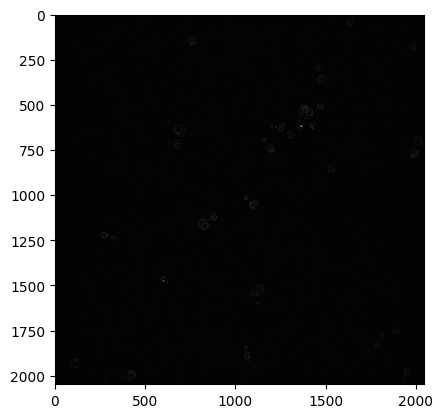

In [5]:
img = skimage.io.imread('./Marco/ASS/WT/MAX_WT-ASS-1-GFP.tif')
footp = skimage.morphology.square(20)
img_enh = skimage.filters.rank.enhance_contrast(img,footprint=footp)

plt.imshow(img_enh,cmap='gray')


In [6]:
# Setting model for the cellpose algorithm and running it to generate a mask for the current image.
model = models.Cellpose(model_type='cyto')
masks, flows, styles, diams = model.eval(img, diameter=60, channels=[[0,0]])
regprop = skimage.measure.regionprops(masks,img)

plt.imshow(masks)


In [367]:
ImgDex = 0

The biggest area in cell number 37/37 has a value of 0


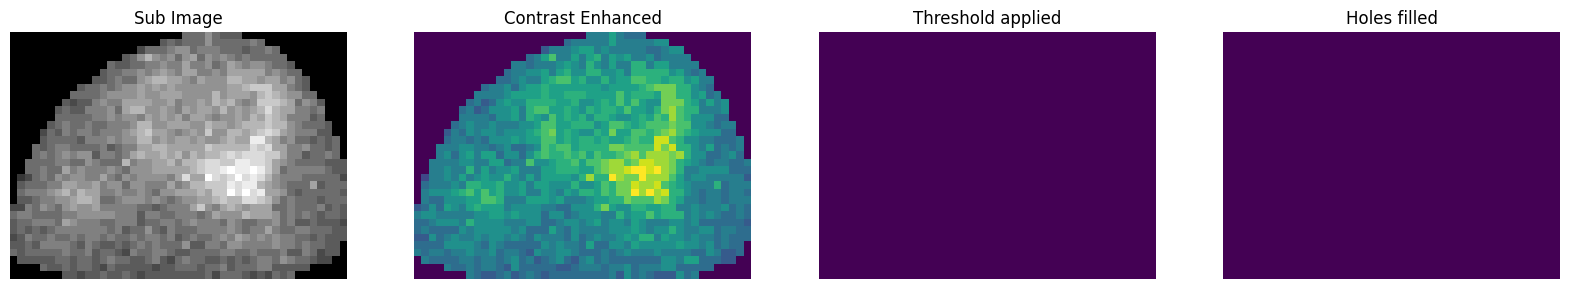

In [404]:
subImg = regprop[ImgDex]['image_intensity']

footp = skimage.morphology.square(2)
contrast = skimage.filters.rank.enhance_contrast(subImg, footp)


thresh = contrast > 20

whole = ndi.binary_fill_holes(thresh)

mask2 = skimage.measure.label(whole)
regP = skimage.measure.regionprops(mask2,subImg)


if len(regP) == 0:
    area = 0
else:
    area = regP[0]['area']
    for ampdex in range(0,len(regP)):
        cArea = regP[ampdex]['area']
        if area < cArea:
            area = cArea

print('The biggest area in cell number {}/{} has a value of {}'.format(ImgDex+1,len(regprop)-1,area))

ImgDex = ImgDex + 1

fig, ax = plt.subplots(1,4,figsize=(20,20))

ax[0].set_title('Sub Image')
ax[0].axis('off')
ax[0].imshow(subImg, cmap='gray')

ax[1].set_title('Contrast Enhanced')
ax[1].axis('off')
ax[1].imshow(contrast)

ax[2].set_title('Threshold applied')
ax[2].axis('off')
ax[2].imshow(thresh)

ax[3].set_title('Holes filled')
ax[3].axis('off')
ax[3].imshow(whole)